# Importing Dependencies and Setup

In [1]:
import os
import cv2
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
path = os.getcwd()
path

'C:\\Users\\sunny\\Machine Learning\\Emotion'

# Extracting the Data

In [4]:
import patoolib

In [5]:
patoolib.extract_archive(os.path.join(path, 'archive.zip'), outdir = path)

patool: Extracting C:\Users\sunny\Machine Learning\Emotion\archive.zip ...
patool: running C:\MinGW\bin\7z.EXE x "-oC:\Users\sunny\Machine Learning\Emotion" -- "C:\Users\sunny\Machine Learning\Emotion\archive.zip"
patool: ... C:\Users\sunny\Machine Learning\Emotion\archive.zip extracted to `C:\Users\sunny\Machine Learning\Emotion'.


'C:\\Users\\sunny\\Machine Learning\\Emotion'

# Understanding the Data

In [8]:
#Getting class labels

class_labels = []

for dir in os.listdir(os.path.join(path, 'train')):
    class_labels.append(dir)

class_labels

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [11]:
img_array = cv2.imread(os.path.join(path, 'train', 'angry', 'im1002.png'))
img_array.shape

(48, 48, 3)

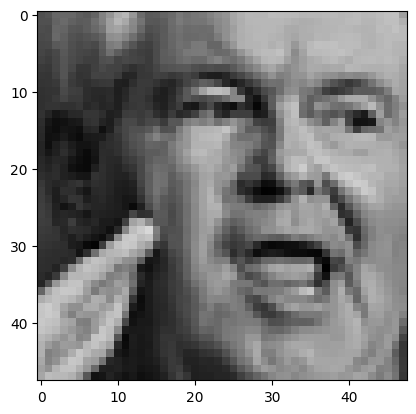

In [12]:
plt.imshow(img_array)

In [13]:
number_of_images_per_category = {}

for cat in os.listdir(os.path.join(path, 'train')):
    number_of_images_per_category[cat] = len(os.listdir(os.path.join(path, 'train', cat)))

number_of_images_per_category    

{'angry': 3995,
 'disgusted': 436,
 'fearful': 4097,
 'happy': 7215,
 'neutral': 4965,
 'sad': 4830,
 'surprised': 3171}

In [14]:
img_size = 48

# Removing Dodgy Images

In [15]:
import imghdr

In [16]:
img_extns = ['jpg', 'jpeg', 'bmp', 'png']

In [17]:
# for image_class in os.listdir(os.path.join(path, 'train')):
#     for image in os.listdir(os.path.join(path, 'train', image_class)):
#         image_path = os.path.join(path, 'train', image_class, image)
#         try:
#             cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in img_extns:
#                 print('Image not in extns list! {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e:
#             print('Issue with image {}'.format(image_path))

#no dodgy images found

# Loading Data and Data Augmentation

In [18]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
train_dir = 'train'
val_dir = 'test'

In [20]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    shear_range = 0.3,
    zoom_range = 0.3,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    horizontal_flip = True,
    fill_mode = 'nearest'
    
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [21]:
img_size = 48
batch_size = 32

In [22]:
train_generator = train_datagen.flow_from_directory(
    'train',
    color_mode = 'grayscale',
    target_size = (img_size, img_size),
    batch_size = batch_size
)

val_generator = validation_datagen.flow_from_directory(
    'test',
    target_size = (img_size, img_size),
    batch_size = batch_size
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
train_generator

# Model

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [30]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 128)      

In [32]:
checkpoint = ModelCheckpoint(
    'model_optimal.h5',
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 3,
    verbose = 1,
    min_delta = 0.0001
)

callbacks = [checkpoint]

In [ ]:
history = model.fit(x = train_generator, epochs = 64, callbacks = callbacks, validation_data = val_generator)